In [7]:
import numpy as np
from matplotlib import pyplot as plt
from utils import CarTrajectoryNonLinear, UKF, plot_trajectory, conf_ellipse

from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from tqdm import tqdm
from scipy.stats import multivariate_normal as mvn

from matplotlib import animation, rc


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats
import numpy as np
from tqdm import tqdm

In [8]:
system = CarTrajectoryNonLinear()
states, measurements = system.get_data()

f = system.f
F_jacobian = system.F_jacobian
h = system.h
H_jacobian = system.H_jacobian
Q = system.Q
R = system.R

In [9]:
extended_kalman_filter = UKF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates, cov_estimates = extended_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extended_kalman_filter.smoother(state_estimates, cov_estimates)

/tmp/ipykernel_11286/2505360608.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  oranges = get_cmap('Oranges')(np.linspace(0.4, 1, len(segments)))


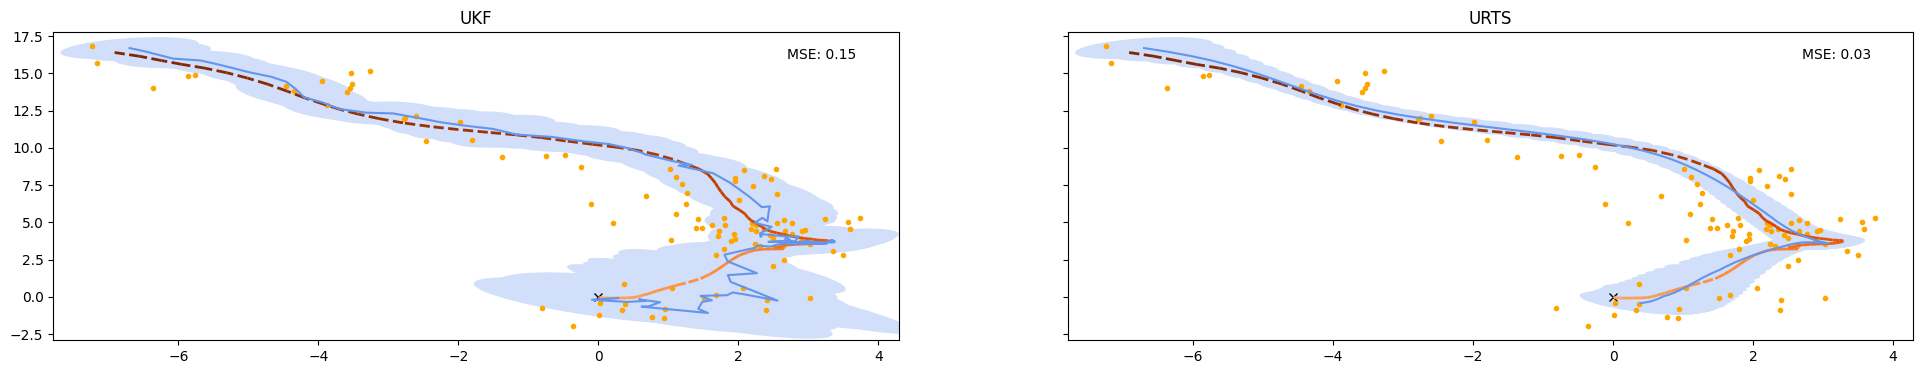

In [10]:
from matplotlib.collections import LineCollection
from matplotlib.cm import get_cmap

#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(24, 4), sharey=True)

for k in range(2):
    ax[k].plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
    #ax[k].plot(states[:, 0], states[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")
    
# Create a set of line segments
points = np.array([states[:, 0], states[:, 1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
oranges = get_cmap('Oranges')(np.linspace(0.4, 1, len(segments)))
lc1 = LineCollection(segments, colors=oranges, linewidths=2, linestyle='--', label="True trajectory")
lc2 = LineCollection(segments, colors=oranges, linewidths=2, linestyle='--', label="True trajectory")

# Plot line
ax[0].add_collection(lc1)
ax[1].add_collection(lc2)
    
plot_trajectory(ax[0], state_estimates, cov_estimates, label="UKF")
ax[0].set_title("UKF")

plot_trajectory(ax[1], state_estimates_smoothed, cov_estimates_smoothed, label="URTS")
ax[1].set_title("URTS")

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(np.mean((states[:, :2] - state_estimates_smoothed[:, :2])**2)),
           horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

plt.show()

In [11]:
class PlotAnimation:

    def __init__(self, states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name="animation"):
        self.states = states
        self.measurements = measurements
        self.state_estimates = state_estimates.copy()
        self.cov_estimates = cov_estimates.copy()
        self.state_estimates_smoothed = state_estimates_smoothed
        self.cov_estimates_smoothed = cov_estimates_smoothed
        self.name = name

        self.fig = plt.figure(figsize=(16, 6))
        self.gs = self.fig.add_gridspec(
            2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
            left=0.1, right=0.9, bottom=0.1, top=0.9,
            wspace=0.05, hspace=0.05
        )

        self.ax = self.fig.add_subplot(self.gs[1, 0])
        self.ax.plot(states[0, 0], states[0, 1], 'x', color='k', label="Start")
        self.ax.plot(states[:, 0], states[:, 1], '--', color='r', label="True trajectory")
        self.ax.plot(measurements[:, 0], measurements[:, 1], '.', color='orange', label="Noisy observations")

        self.ax_histx = self.fig.add_subplot(self.gs[0, 0], sharex=self.ax)
        self.ax_histy = self.fig.add_subplot(self.gs[1, 1], sharey=self.ax)
        self.line, = self.ax.plot([], [], '-', color='black', label="Estimated trajectory")
        self.mse_text = self.fig.text(0.75, 0.75, '', transform=self.fig.transFigure, fontsize=12)

        self.ax_histx.tick_params(axis="x", labelbottom=False)
        self.ax_histy.tick_params(axis="y", labelleft=False)

    def update_trajectory(self, frame):
        self.line.set_xdata(self.state_estimates[:frame, 0])
        self.line.set_ydata(self.state_estimates[:frame, 1])

        if frame > 0:
            mse = np.mean((self.states[:frame, :2] - self.state_estimates[:frame, :2]) ** 2)
            self.mse_text.set_text(f'MSE: {mse:.2f}')

    def update_histogram(self, frame):
        self.ax_histx.clear()
        self.ax_histy.clear()
        self.ax_histx.set_ylim(0, 1.5)
        self.ax_histy.set_xlim(0, 1.5)

        tmp_x = np.linspace(
            self.state_estimates[frame, 0] - 3 * np.sqrt(self.cov_estimates[frame, 0, 0]),
            self.state_estimates[frame, 0] + 3 * np.sqrt(self.cov_estimates[frame, 0, 0]), 100
        )

        self.ax_histx.plot(
            tmp_x, scipy.stats.norm.pdf(tmp_x, self.state_estimates[frame, 0], np.sqrt(self.cov_estimates[frame, 0, 0])), color='black')

        tmp_y = np.linspace(
            self.state_estimates[frame, 1] - 3 * np.sqrt(self.cov_estimates[frame, 1, 1]),
            self.state_estimates[frame, 1] + 3 * np.sqrt(self.cov_estimates[frame, 1, 1]), 100
        )

        self.ax_histy.plot(
            scipy.stats.norm.pdf(tmp_y, self.state_estimates[frame, 1], np.sqrt(self.cov_estimates[frame, 1, 1])), tmp_y, color='black')

    def init(self):
        self.ax.set_xlim(int(np.min(self.measurements[:, 0]) - 5), int(np.max(self.measurements[:, 0] + 5)))
        self.ax.set_ylim(int(np.min(self.measurements[:, 1]) - 5), int(np.max(self.measurements[:, 1] + 5)))
        self.ax_histx.set_ylim(0, 1.0)
        self.ax_histy.set_xlim(0, 1.0)
        return self.ax,

    def update_filter(self, frame):
        self.ax.plot(self.measurements[frame, 0], self.measurements[frame, 1], '.', color='orange',
                     label="Noisy observations")
        
        conf_ellipse(self.ax, state_estimates[frame, :2], cov_estimates[frame, :2, :2])

        self.update_trajectory(frame)
        self.update_histogram(frame)
        
        return self.ax,

    def update_smoother(self, frame):
        frame = frame - len(self.state_estimates)
        self.ax.plot(self.measurements[frame, 0], self.measurements[frame, 1], '.', color='orange',
                     label="Noisy observations")

        self.state_estimates[-frame:] = self.state_estimates_smoothed[-frame:]
        self.cov_estimates[-frame:] = self.cov_estimates_smoothed[-frame:]

        conf_ellipse(self.ax, state_estimates[frame, :2], cov_estimates[frame, :2, :2])

        self.update_trajectory(len(self.state_estimates) - 1)

        frame = -frame - 1
        self.update_histogram(frame)

        return self.ax,

    def update(self, frame):
        if frame < len(self.state_estimates):
            ax = self.update_filter(frame)
        else:
            ax = self.update_smoother(frame - len(self.state_estimates))

        return ax,

    def animate(self):
        with tqdm(total=2 * len(self.state_estimates)) as pbar:
            ani = animation.FuncAnimation(
                self.fig, self.update, frames=range(0, 2 * len(self.state_estimates)), init_func=self.init
            )
            ani.save(f'{self.name}.gif', writer='Pillow', fps=7, progress_callback=lambda i, n: pbar.update())



100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


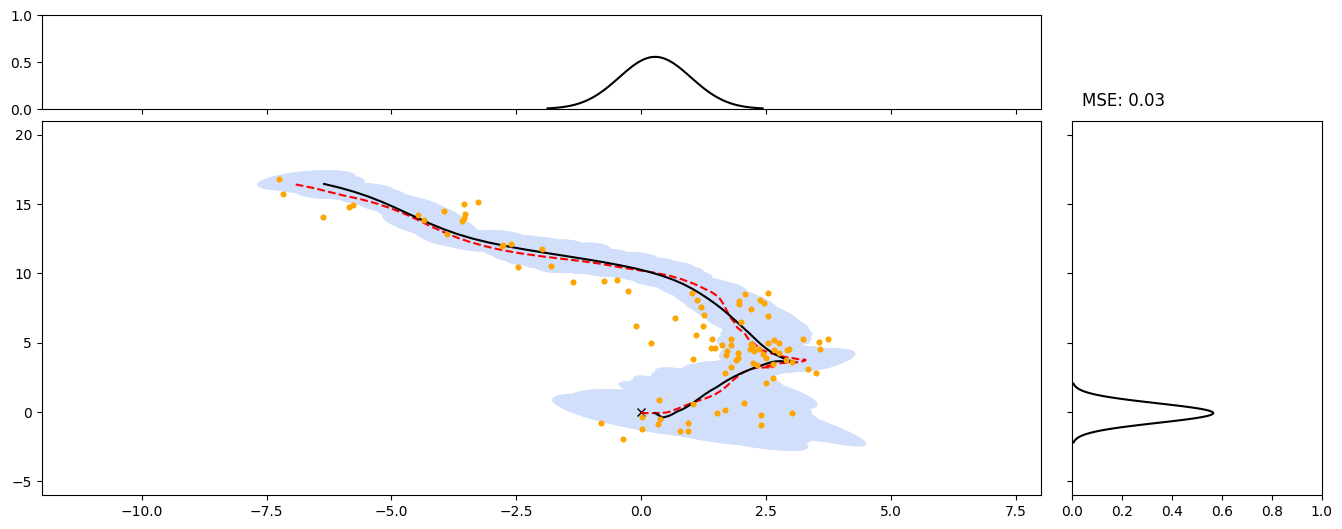

In [12]:
unscented_plot = PlotAnimation(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, name="unscented")
unscented_plot.animate()